In [111]:
import pandas as pd
from graphdatascience import GraphDataScience # Load neo4j graph data science library
import os
import matplotlib.pyplot as plt

if os.getcwd().split('\\')[-1] == 'notebooks':
    os.chdir('..')

# Modeling
from flaml import AutoML
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [51]:
# Connect to a Neo4j instance (assumes local right now)
NEO4J_URI = os.environ.get("NEO4J_URI", "bolt://localhost:7687")
NEO4J_AUTH = None
NEO4J_DB = os.environ.get("NEO4J_DB", "neo4j")
if os.environ.get("NEO4J_USER") and os.environ.get("NEO4J_PASSWORD"):
    NEO4J_AUTH = (
        os.environ.get("NEO4J_USER"),
        os.environ.get("NEO4J_PASSWORD"),
    )
else:
    NEO4J_AUTH = ("neo4j", "Bookings")
gds = GraphDataScience(NEO4J_URI, auth=NEO4J_AUTH, database=NEO4J_DB)

### Build the training data by finding positive and negative examples of bookings

In [52]:
train_positive = gds.run_cypher("""
MATCH (p:Property)-[:TRAIN_BOOKING]->(w:Week)
RETURN DISTINCT
    p.id AS property_id
,   w.week_num AS week_num
,   w.week_degree AS week_degree
,   p.capacity AS capacity
,   p.pets_allowed AS pets_allowed
,   p.property_embedding AS property_embedding
,   1 AS is_booked
""")

In [53]:
# Find all properties that had did not have a booking in the current week, but had a booking in at least one of the previous two weeks
negative_weeks_ahead = gds.run_cypher("""
MATCH (p:Property)
MATCH (w:Week)
WHERE (p)-[:TRAIN_BOOKING]->()
MATCH (p)-[:TRAIN_BOOKING]->(:Week)-[:PRECEDES*1..4]->(w)
WHERE NOT (p)-[:TRAIN_BOOKING]->(w)
RETURN DISTINCT
    p.id AS property_id
,   w.week_num AS week_num
,   w.week_degree AS week_degree
,   p.capacity AS capacity
,   p.pets_allowed AS pets_allowed
,   p.property_embedding AS property_embedding
,   0 AS is_booked
""")

In [54]:
# Switch the order of the relationship in the second match
negative_weeks_behind = gds.run_cypher("""
MATCH (p:Property)
MATCH (w:Week)
WHERE (p)-[:TRAIN_BOOKING]->()
MATCH (p)-[:TRAIN_BOOKING]->(:Week)<-[:PRECEDES*1..4]-(w)
WHERE NOT (p)-[:TRAIN_BOOKING]->(w)
RETURN DISTINCT
    p.id AS property_id
,   w.week_num AS week_num
,   w.week_degree AS week_degree
,   p.capacity AS capacity
,   p.pets_allowed AS pets_allowed
,   p.property_embedding AS property_embedding
,   0 AS is_booked
""")

In [55]:
# Properties that were not booked on a given week where a totally different property was booked that week in the same city
negative_same_city_diff_attrs = gds.run_cypher("""
MATCH (p:Property)-[:LOCATED_IN]->(c:City)
MATCH (p)-[:HAS_TYPE]->(t:Type)
MATCH (w:Week)
WHERE (p)-[:TRAIN_BOOKING]->()
MATCH (c)<-[:LOCATED_IN]-(p2:Property)-[:TRAIN_BOOKING]->(w)
MATCH (p2)-[:HAS_TYPE]->(t2:Type)
WHERE NOT (p)-[:TRAIN_BOOKING]->(w)
    AND p2.capacity <> p.capacity
    AND p2.pets_allowed <> p.pets_allowed
    AND t2 <> t
RETURN DISTINCT
    p.id AS property_id
,   w.week_num AS week_num
,   w.week_degree AS week_degree
,   p.capacity AS capacity
,   p.pets_allowed AS pets_allowed
,   p.property_embedding AS property_embedding
,   0 AS is_booked
""")

In [126]:
# Import additional data sources from feature engineering
city_week_pref_attachment = pd.read_csv('Inputs/city_week_pref_attachment.csv')

In [127]:
# Get the property to city mapping
property_city_mapping = gds.run_cypher("""
MATCH (p:Property)-[:LOCATED_IN]->(c:City)
RETURN DISTINCT p.id AS property_id, c.name AS city
""")

In [128]:
# Combine the various datasets
train_data = pd.concat([train_positive, negative_weeks_ahead, negative_weeks_behind, negative_same_city_diff_attrs], axis = 0)

# Expand the property_embedding column into individual columns
p_embedding_cols = [f"property_embedding___{i + 1}" for i in range(len(train_data.iloc[0].property_embedding))]
train_data[p_embedding_cols] = train_data['property_embedding'].apply(pd.Series)
train_data.drop(columns = ['property_embedding'], inplace = True)
train_data = train_data.drop_duplicates()

# Merge in the city_week_pref_attachment data
train_data = (
    train_data
    .merge(property_city_mapping, on = 'property_id', how = 'left')
    .merge(city_week_pref_attachment, how = 'left', on = ['city', 'week_num'])
    .drop(columns = 'city') # This is included in the embedding, so we don't need it twice
)

In [129]:
print(train_data.shape)
train_data.head()

(21380, 71)


,property_id,week_num,week_degree,capacity,pets_allowed,is_booked,property_embedding___1,property_embedding___2,property_embedding___3,property_embedding___4,...,property_embedding___56,property_embedding___57,property_embedding___58,property_embedding___59,property_embedding___60,property_embedding___61,property_embedding___62,property_embedding___63,property_embedding___64,city_week_pref_attachment
0,683,31,982.0,5,yes,1,0.0,0.000000,0.000000,0.000000,...,0.223607,-0.223607,0.000000,-0.223607,0.0,0.0,0.0,0.000000,-0.223607,354798.0
1,938,31,982.0,5,yes,1,0.0,0.208514,0.208514,0.208514,...,0.000000,-0.208514,-0.208514,0.000000,0.0,0.0,0.0,0.000000,0.000000,203109.0
2,690,31,982.0,4,no,1,0.0,0.000000,0.000000,0.223607,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,-0.223607,0.223607,185112.0
3,886,31,982.0,8,yes,1,0.0,0.000000,0.000000,0.000000,...,0.223607,-0.223607,0.000000,-0.223607,0.0,0.0,0.0,0.000000,-0.223607,354798.0
4,221,31,982.0,5,yes,1,0.0,0.000000,0.000000,0.000000,...,0.223607,-0.223607,0.000000,-0.223607,0.0,0.0,0.0,0.000000,-0.223607,365082.0


### Do the same thing for the test data
should functionize this to minimize code duplication

In [130]:
test_positive = gds.run_cypher("""
MATCH (p:Property)-[:HOLDOUT_BOOKING]->(w:Week)
RETURN DISTINCT
    p.id AS property_id
,   w.week_num AS week_num
,   w.week_degree AS week_degree
,   p.capacity AS capacity
,   p.pets_allowed AS pets_allowed
,   p.property_embedding AS property_embedding
,   1 AS is_booked
""")

In [131]:
# Find all properties that had did not have a booking in the current week, but had a booking in at least one of the previous two weeks
test_negative_weeks_ahead = gds.run_cypher("""
MATCH (p:Property)
MATCH (w:Week)
WHERE (p)-[:HOLDOUT_BOOKING]->()
MATCH (p)-[:HOLDOUT_BOOKING]->(:Week)-[:PRECEDES*1..4]->(w)
WHERE NOT (p)-[:HOLDOUT_BOOKING]->(w)
RETURN DISTINCT
    p.id AS property_id
,   w.week_num AS week_num
,   w.week_degree AS week_degree
,   p.capacity AS capacity
,   p.pets_allowed AS pets_allowed
,   p.property_embedding AS property_embedding
,   0 AS is_booked
""")

In [132]:
# Switch the order of the relationship in the second match
test_negative_weeks_behind = gds.run_cypher("""
MATCH (p:Property)
MATCH (w:Week)
WHERE (p)-[:HOLDOUT_BOOKING]->()
MATCH (p)-[:HOLDOUT_BOOKING]->(:Week)<-[:PRECEDES*1..4]-(w)
WHERE NOT (p)-[:HOLDOUT_BOOKING]->(w)
RETURN DISTINCT
    p.id AS property_id
,   w.week_num AS week_num
,   w.week_degree AS week_degree
,   p.capacity AS capacity
,   p.pets_allowed AS pets_allowed
,   p.property_embedding AS property_embedding
,   0 AS is_booked
""")

In [133]:
# Properties that were not booked on a given week where a totally different property was booked that week in the same city
test_negative_same_city_diff_attrs = gds.run_cypher("""
MATCH (p:Property)-[:LOCATED_IN]->(c:City)
MATCH (p)-[:HAS_TYPE]->(t:Type)
MATCH (w:Week)
WHERE (p)-[:HOLDOUT_BOOKING]->()
MATCH (c)<-[:LOCATED_IN]-(p2:Property)-[:HOLDOUT_BOOKING]->(w)
MATCH (p2)-[:HAS_TYPE]->(t2:Type)
WHERE NOT (p)-[:HOLDOUT_BOOKING]->(w)
    AND p2.capacity <> p.capacity
    AND p2.pets_allowed <> p.pets_allowed
    AND t2 <> t
RETURN DISTINCT
    p.id AS property_id
,   w.week_num AS week_num
,   w.week_degree AS week_degree
,   p.capacity AS capacity
,   p.pets_allowed AS pets_allowed
,   p.property_embedding AS property_embedding
,   0 AS is_booked
""")

In [134]:
# Combine the various datasets
test_data = pd.concat([test_positive, test_negative_weeks_ahead, test_negative_weeks_behind, test_negative_same_city_diff_attrs], axis = 0)

# Expand the property_embedding column into individual columns
p_embedding_cols = [f"property_embedding___{i + 1}" for i in range(len(test_data.iloc[0].property_embedding))]
test_data[p_embedding_cols] = test_data['property_embedding'].apply(pd.Series)
test_data.drop(columns = ['property_embedding'], inplace = True)
test_data = test_data.drop_duplicates()

# Merge in the city_week_pref_attachment data
test_data = (
    test_data
    .merge(property_city_mapping, on = 'property_id', how = 'left')
    .merge(city_week_pref_attachment, how = 'left', on = ['city', 'week_num'])
    .drop(columns = 'city') # This is included in the embedding, so we don't need it twice
)

In [135]:
test_data.value_counts('is_booked')

is_booked
0    10981
1     9266
Name: count, dtype: int64

# Model training

In [136]:
X_train = train_data.drop(columns = ['is_booked', 'property_id'])
y_train = train_data['is_booked']

X_test = test_data.drop(columns = ['is_booked', 'property_id'])
y_test = test_data['is_booked']

In [137]:
settings = {
    "time_budget": 120,  # total running time in seconds
    "metric": 'f1',  # primary metrics can be chosen from: ['accuracy','roc_auc','f1','log_loss']
    "task": 'classification',  # task type
    "estimator_list": ['lgbm', 'xgb_limitdepth'],  # list of ML learners
}

automl = AutoML()
automl.fit(X_train, y_train, **settings)

[flaml.automl.logger: 08-29 02:28:42] {1680} INFO - task = classification
[flaml.automl.logger: 08-29 02:28:42] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 08-29 02:28:42] {1789} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 08-29 02:28:42] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgb_limitdepth']
[flaml.automl.logger: 08-29 02:28:42] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 08-29 02:28:42] {2345} INFO - Estimated sufficient time budget=652s. Estimated necessary time budget=4s.
[flaml.automl.logger: 08-29 02:28:42] {2392} INFO -  at 0.3s,	estimator lgbm's best error=0.2246,	best estimator lgbm's best error=0.2246
[flaml.automl.logger: 08-29 02:28:42] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 08-29 02:28:42] {2392} INFO -  at 0.4s,	estimator lgbm's best error=0.2246,	best estimator lgbm's best error=0.2246
[flaml.automl.logger: 08-29 02:28:42] {2219} INFO - iteration 2, current lea

In [138]:
print(automl.best_estimator)
print(automl.best_config)
print(automl.score(X_train, y_train, metric='accuracy'))
print(automl.score(X_test, y_test, metric='accuracy'))

xgb_limitdepth
{'n_estimators': 216, 'max_depth': 7, 'min_child_weight': 0.259949046439129, 'learning_rate': 0.02753608497193262, 'subsample': 0.8971767792389439, 'colsample_bylevel': 0.598132805254548, 'colsample_bytree': 0.9291439951904144, 'reg_alpha': 80.40768009447709, 'reg_lambda': 173.53435873284334}
0.7380729653882133
0.6954116659258162


Text(0, 0.5, '')

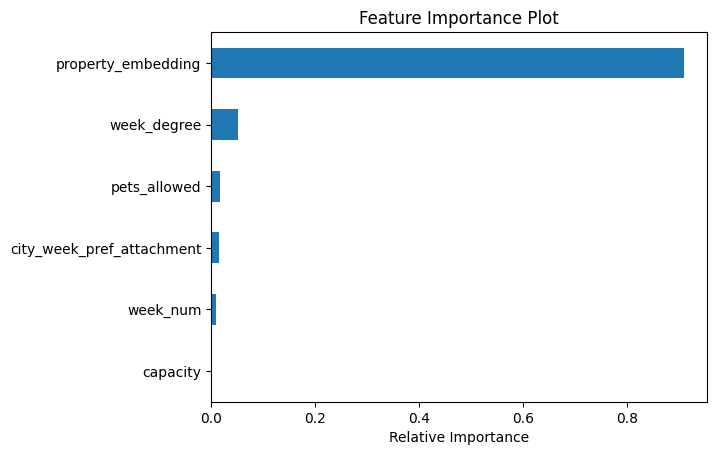

In [139]:
(
    pd.DataFrame(zip(automl.feature_names_in_, automl.feature_importances_), columns=['Feature', 'Importance'])
    .sort_values('Importance', ascending = False)
    .assign(grouped_feature = lambda x: x['Feature'].apply(lambda y: y.split('___')[0]))
    .groupby('grouped_feature')['Importance'].sum().sort_values(ascending = True)
).plot(kind = 'barh', title = 'Feature Importance Plot')
plt.xlabel('Relative Importance')
plt.ylabel('')

In [140]:
# Predict on the test set
y_pred = automl.predict(X_test)

In [144]:
# Create a confusion matrix
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ['Predicted Not Booked', 'Predicted Booked'])
conf_mat.index = ['Actual Not Booked', 'Actual Booked']
conf_mat

,Predicted Not Booked,Predicted Booked
Actual Not Booked,8653,2328
Actual Booked,3839,5427


In [145]:
precision_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.6998065764023211, 0.5856896179581265)